In [83]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix
from pyarrow.feather import read_feather
import matplotlib.pyplot as plt
import pandas as pd
import sys
import sklearn
import numpy as np

%matplotlib inline

In [38]:
sys.path.append("F:\Valentina\Experiments\exp_lookback\mylib")
import cv_toolkit as mycv

In [2]:
def get_cols(df, stem):
    return [col for col in list(df) if stem in col]

In [3]:
#set parameters
filename = "F:\\Valentina\\Experiments\\exp_lookback\\extra_data\\st_combined_train_unmatched_test_capped_freq_datediff_alldays.feather"
last_exp_stem = 'LAST_EXP_'
label = "label"
pos_label = 1
neg_label = 0

In [60]:
#select columns from dataset
df = read_feather(filename)
exp_cols = get_cols(df, last_exp_stem)
cols = exp_cols + [label]
df = df[cols]

In [61]:
#set 1:50 ratio
ratio = 50
n_pos = df[df[label] == pos_label].shape[0]
n_neg = df[df[label] == neg_label].shape[0]
n_sample_neg = n_pos *ratio
sampled_neg = df[df[label] == neg_label].sample(n= n_sample_neg, random_state = 2)
sampled_df = pd.concat([df[df[label] == pos_label], sampled_neg])
sampled_df = sampled_df.reset_index(drop=True)

In [15]:
print(n_pos, n_neg, n_pos*50, n_pos +n_pos*50)

1553 1628335 77650 79203


In [17]:
print(sampled_df.shape)

(79203, 342)


In [33]:
#using sklearn methods
model = XGBClassifier
kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
results = cross_val_score(estimator = model,
                          X = sampled_df[exp_cols], 
                          y = sampled_df[label], 
                          cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 99.26% (0.03%)


In [69]:
#using Shaun library for cv
#model = XGBClassifier(n_estimators = 50)
model = XGBClassifier()
kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
cv_outputs = mycv.run_CV(X = sampled_df[exp_cols], 
                         y = sampled_df[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)

In [72]:
eval_metrics = [precision_recall_curve, accuracy_score, confusion_matrix]
output_metrics ={}
output_metrics['All'] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)


Text(0,0.5,'Precision')

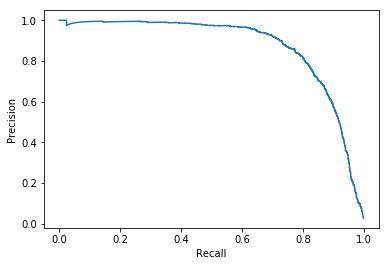

In [78]:
pd.DataFrame.from_dict(output_metrics['All']['precision_recall_curve']).plot(x='recall', y='precision', legend=False)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [80]:
def cut_lookback(x, max_days):
    return x.where(x <= max_days, np.nan)

def cut_df(df, yrs):
    df_tmp = df.copy()
    for col in list(df):
        df_tmp[col] = cut_lookback(df_tmp[col], 365*yrs)
    return df_tmp

In [98]:
#performing loop on different selection of features
output_metrics ={}
model = XGBClassifier
params = {'n_estimators': 50}
model_features = {'ALL': 5, '2 yrs': 2, '1yr': 1}

for model_name, looklength in model_features.items():
    print(model_name)
    print("Computing dataframe...")
    modelling_data = cut_df(sampled_df, looklength)
    print("Running crossvalidation...")
    cv_outputs = mycv.run_CV(X = modelling_data[exp_cols], 
                         y = modelling_data[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)
    print("Computing metrics...")
    output_metrics[model_name] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)


ALL
Computing dataframe...
Running crossvalidation...
Computing metrics...
2 yrs
Computing dataframe...
Running crossvalidation...
Computing metrics...
1yr
Computing dataframe...
Running crossvalidation...
Computing metrics...


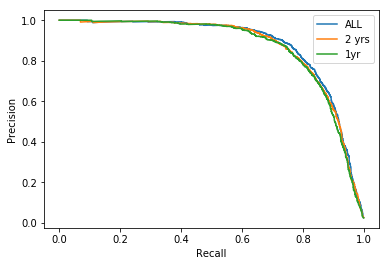

In [91]:
for model in output_metrics.keys():
    pr = pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve'])
    plt.plot(pr['recall'], pr['precision'], label = model)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [99]:
cv_outputs

{'fold_metrics': {'test': [{}, {}, {}, {}, {}], 'train': []},
 'models': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
         n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=1),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
         n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=1),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1